# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to GMM and SVD.

## Exercise 1 (25 points)

In this exercise we will implement 1-dimensional GMM clustering algorithm from scratch. A GMM distribution is composed of `k` components, each characterized by:

1. A mixture proportion
2. A mean for its Normal Distribution
3. A variance for its Normal Distribution

So, to generate a dataset that follows a GMM dsitrbution we need a list of those parameters. In this exercise we will use a class called `Component` to capture the parameters for a given component. And a GMM will be a list of `Component`s.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/CS506-Spring23-Homework3")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CS506_homework3_solutions.ipynb  mnist_784.csv


In [ ]:
class Component:
    def __init__(self, mixture_prop, mean, variance):
        self.mixture_prop = mixture_prop
        self.mean = mean
        self.variance = variance

example_gmm = [Component(.5, 5, 1), Component(.5, 8, 1)]


a) Complete the function below to validate and generate a dataset following a GMM distribution, given a specified set of GMM parameters as above and a size. You may only use the methods already imported in the cell. (10pts)

In [ ]:
from numpy.random import normal, uniform

def generate_gmm_dataset(gmm_params, size):
    if not is_valid_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        dataset.append(normal(comp.mean, comp.variance))    #TODO
    return dataset

def is_valid_gmm(gmm_params):
    '''
        Checks that the sum of the mixture
        proportions is 1
    '''
    #TODO
    return abs(sum([comp.mixture_prop for comp in gmm_params]) - 1) < 1e-6  #added tolerance

def get_random_component(gmm_params):
    '''
        returns component with prob
        proportional to mixture_prop
    '''
    #TODO
    r = uniform()
    total = 0
    for comp in gmm_params:
        total += comp.mixture_prop
        if r <= total:
            return comp
    return gmm_params[-1]  # return last component if we fall off the end

# test your code: this should return a list of 10 numbers similar to worksheet 8
data = generate_gmm_dataset(example_gmm, 10)
data

[4.13774094131783,
 8.846974865934586,
 7.872263791833184,
 5.292094340859974,
 4.423978054340923,
 8.745417066326064,
 4.441615027481394,
 7.055010621480804,
 4.868679746839044,
 4.962202369555102]

*NOTE*: The data generated is not unique.

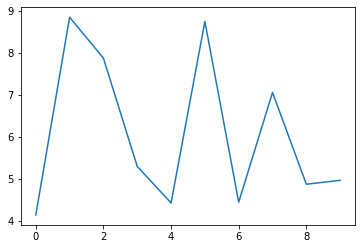

In [ ]:
#extra
import matplotlib.pyplot as plt
plt.plot(data)

*Explaination: Code first checks that the GMM parameters are valid by ensuring that the sum of the mixture proportions is close enough to 1 (within a tolerance of 1e-6). Then it generates a dataset of the specified size by looping size times and selecting a random component based on the mixture proportions. Finally, it generates a random number from a normal distribution with the mean and variance of the selected component, and adds it to the dataset.*

*Note that the `get_random_component` function uses the `uniform` function from numpy.random to generate a random number between 0 and 1, and then loops over the GMM components until it finds the component whose mixture proportion "contains" this random number. This is done by keeping track of a running total of the mixture proportions, and returning the first component whose total mixture proportion is greater than the random number. If we fall off the end of the loop, we return the last component in the list (which should have a total mixture proportion of 1, so it will always be selected if the loop fails to find a matching component)*

b) Finish the implementation below of the Expectation-Maximization Algorithm. Only use methods that have been imported in the cell. (15pts)

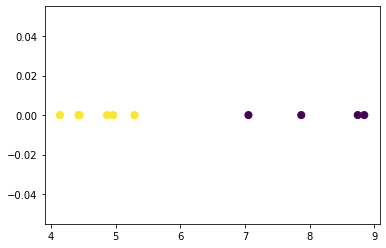

In [ ]:
from scipy.stats import norm
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def gmm_init(k, dataset):
    kmeans = KMeans(k, init='k-means++').fit(X=array(dataset).reshape(-1, 1))
    gmm_params = []
    #TODO
    for i in range(k):
        comp = Component(1 / k, kmeans.cluster_centers_[i][0], 1)
        gmm_params.append(comp)
    return gmm_params


def compute_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j
    '''
    gmm_params = []
    #TODO
    for j in range(k):
        # compute new mixture proportion
        mixture_prop = sum(probs[i][j] for i in range(len(dataset))) / len(dataset)
        # compute new mean
        mean = sum(probs[i][j] * dataset[i] for i in range(len(dataset))) / sum(probs[i][j] for i in range(len(dataset)))
        # compute new variance
        variance = sum(probs[i][j] * (dataset[i] - mean) ** 2 for i in range(len(dataset))) / sum(probs[i][j] for i in range(len(dataset)))
        # add new component
        comp = Component(mixture_prop, mean, variance)
        gmm_params.append(comp)
    return gmm_params


def compute_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
    '''
    probs = []
    #TODO
    for i in range(len(dataset)):
        x = dataset[i]
        p = []
        for j in range(k):
            comp = gmm_params[j]
            p_j = comp.mixture_prop * norm.pdf(x, loc=comp.mean, scale=comp.variance ** 0.5)
            p.append(p_j)
        sum_p = sum(p)
        if sum_p == 0:
            # if sum_p is 0, set all probs to 0
            probs.append([0] * k)
        else:
            probs.append([p[j] / sum_p for j in range(k)])
    return probs


def expectation_maximization(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_gmm(k, dataset, probs)

    return probs, gmm_params


# for testing: you should see smaller sized points
# near the boundary of a cluster if it is close to another cluster
probs, gmm_p = expectation_maximization(2, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2  # square to emphasize the difference
plt.scatter(data, [0.0 for _ in range(len(data))], c=labels, cmap='viridis', s=size)
plt.show()

*NOTE:* Output is not unique.

Notes:

1. your code should work with any number of components, each with reasonable parameters.
2. your code should work for 1 to about 5 iterations of the EM algorithm. It may not work for iterations over 10 because the math we are doing may overflow and create `nans` - that's ok / don't worry about it.
3. worksheet 7 is your friend

*Explaination: Note that the Component class from the previous question is used in this implementation. The gmm_init function initializes the GMM parameters using K-means clustering, and the compute_gmm function computes the new GMM parameters based on the current probabilities. The compute_probs function computes the probabilities for each point in the dataset given the current GMM parameters. Finally, the expectation_maximization function performs the full EM algorithm by iterating over the expectation and maximization steps. The resulting probabilities and GMM parameters can then be used to cluster the data.*

## Exercise 2 (50 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (2.5 points)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore")

In [ ]:
X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

# your code here
df = pd.DataFrame(data=X)
df['label'] = y
df.to_csv('mnist_784.csv', index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [ ]:
#directly import csv from here
df = pd.read_csv('mnist_784.csv')
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


b) Plot the singular value plot for a single example of the 0 digit (2.5 points)

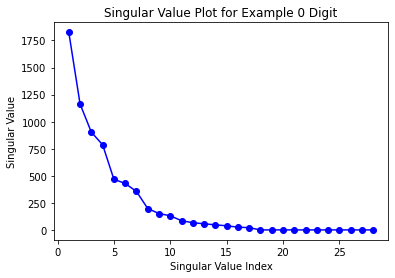

In [ ]:
# Select an example (over here the first occurance) of the 0 digit
example = df[df['label'] == 0].iloc[0, :-1].to_numpy()

# Perform singular value decomposition (SVD)
U, S, V = np.linalg.svd(example.reshape(28, 28))

# Plot singular values
plt.plot(np.arange(1, len(S)+1), S, 'bo-')
plt.title("Singular Value Plot for Example 0 Digit")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.show()

c) Just like we did in class with the image of the boat: By setting some singular values to 0, plot the approximation of an image of a 0 digit next to the original image. (10 points)

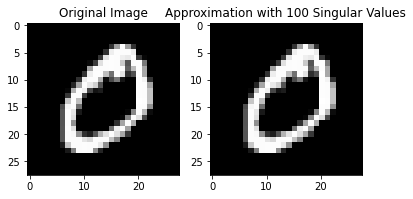

In [ ]:
# Set some singular values to 0
num_singular_values = 100 #choice made at random
S[num_singular_values:] = 0

# Reconstruct the image using the modified SVD
approx = U.dot(np.diag(S)).dot(V)

# Plot the original and approximated images side by side
fig, axs = plt.subplots(1, 2)
axs[0].imshow(example.reshape(28, 28), cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(approx, cmap='gray')
axs[1].set_title("Approximation with {} Singular Values".format(num_singular_values))
plt.show()

d) Consider the entire dataset as a matrix. Perform SVD and explain why / how you chose a particular rank. Note: you may not be able to run this on the entire dataset in a reasonable amount of time so you may take a small random sample for this and the following questions. (5 points)

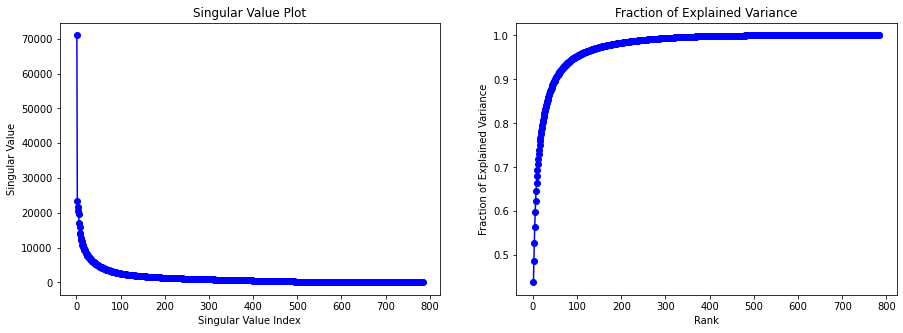

In [ ]:
#taking a sample of data since session keeps crashing and doing it on cuda seems unnecessary
sample_df = df.sample(n=2000, random_state=42)
X = sample_df.iloc[:, :-1].values

# Compute SVD on the dataset
U, S, V = np.linalg.svd(X)

# Compute fraction of explained variance
total_variance = sum(S ** 2)
explained_variance = np.cumsum(S ** 2) / total_variance

fig, axs = plt.subplots(1,2, sharex=True, figsize = (15,5))
# Plot singular values
axs[0].plot(np.arange(1, len(S)+1), S, 'bo-')
axs[0].set_title("Singular Value Plot")
axs[0].set_xlabel("Singular Value Index")
axs[0].set_ylabel("Singular Value")

# Plot fraction of explained variance as a function of rank
axs[1].plot(np.arange(1, len(explained_variance)+1), explained_variance, 'bo-')
axs[1].set_title("Fraction of Explained Variance")
axs[1].set_xlabel("Rank")
axs[1].set_ylabel("Fraction of Explained Variance")
plt.show()

Taken a rank of 50 because that is where the elbow point seems to be for the sample data



e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. Note: the centroids should be represented as images. (10 points)

Clustering accuracy on reconstructed dataset: 0.038


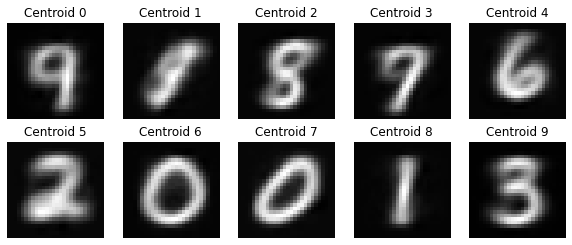

In [ ]:
# Choose a rank to reconstruct the data
rank = 50

# Reconstruct the data using the chosen rank
X_approx = U[:, :rank] @ np.diag(S[:rank]) @ V[:rank, :]

# Perform k-means clustering on the reconstructed data
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X_approx)

# Evaluate the clustering performance using the true labels
true_labels = sample_df.iloc[:, -1].values
accuracy = np.mean(labels == true_labels)
print(f'Clustering accuracy on reconstructed dataset: {accuracy:.3f}')


# Plot the centroids
centroids = kmeans.cluster_centers_.reshape((-1, 28, 28))
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(centroids[i], cmap='gray')
    ax.set_title(f'Centroid {i}')
    ax.axis('off')
plt.tight_layout
plt.show()

NOTE: output shown here is not unique, may vary due to random sampling.

f) Repeat e) on the original dataset (if you used a subset of the dataset, keep using that same subset). Comment on any differences (or lack thereof) you observe between the centroids. (5 points)

Clustering accuracy on orginal sample of dataset: 0.038


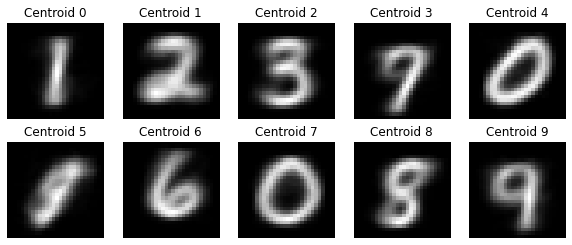

In [ ]:
# Perform k-means clustering on original data
kmeans_original = KMeans(n_clusters=10, random_state=42)
labels_original = kmeans.fit_predict(X)

# Evaluate the clustering performance using the true labels
accuracy_original = np.mean(labels_original == true_labels)
print(f'Clustering accuracy on orginal sample of dataset: {accuracy:.3f}')


# Plot the centroids
centroids = kmeans.cluster_centers_.reshape((-1, 28, 28))
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(centroids[i], cmap='gray')
    ax.set_title(f'Centroid {i}')
    ax.axis('off')
plt.tight_layout
plt.show()

We can see that we have the same accuracy on the orignal and reconstructed dataset; we chose the correct rank, SVD preserves important data information

*NOTE:* output shown here is not unique, may vary due to random sampling. But should be close to the output in prev question.

g) Create a matrix (let's call it `O`) that is the difference between the original dataset and the rank-10 approximation of the dataset. (5 points)

In [ ]:
rank = 10
X_approx = U[:, :rank] @ np.diag(S[:rank]) @ V[:rank, :]

# Compute the difference matrix
O = X - X_approx
print(O)

[[-3.27735701e-14 -9.85992138e-13 -3.74066928e-13 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.69095838e-15 -4.36753485e-13 -6.61907760e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.86873252e-15 -4.94117621e-13  7.23493442e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-3.69755742e-15 -4.69187664e-13 -2.71354394e-13 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.28047637e-15 -8.60966663e-13  1.90706320e-13 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.87428767e-15 -1.51822896e-13  1.20635806e-13 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


h) The largest (using euclidean distance from the origin) rows of the matrix `O` could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows of that matrix `O`. (10 points)

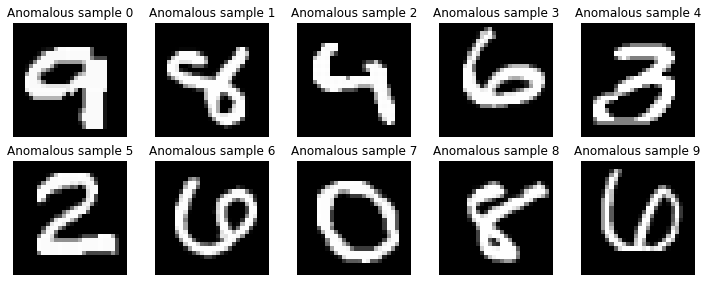

In [ ]:
# Compute the row-wise Euclidean norm of O
norm_O = np.linalg.norm(O, axis=1)

# Get the indices of the 10 largest norm values
largest_indices = norm_O.argsort()[-10:][::-1]

# Get the corresponding rows from the original dataset
largest_rows = X[largest_indices]

# Plot the largest rows as images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(largest_rows[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Anomalous sample {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

The largest rows of the matrix O can be considered anomalous data points because they represent the samples that are farthest from the low-rank approximation. In other words, these are the samples that deviate the most from the subspace spanned by the top singular vectors, which capture most of the information in the dataset. Such samples may represent outliers or noise in the dataset, or they may have different characteristics that are not captured by the low-rank approximation.

*NOTE:* output shown here is not unique, may vary due to random sampling.

In [ ]:
#Alternate method
def euclid_dist(x, y):
    return np.sqrt(np.sum((x-y)**2))

#Plot the 10 images responsible for the 10 largest rows of O
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

X_df_subset['euclid_dist'] = O.apply(lambda x: euclid_dist(x, np.zeros(len(x))), axis=1)

top_10_X_df = X_df_subset.sort_values(by='euclid_dist', ascending=False).head(10)

#get rid of the euclid_dist column
top_10_X_df = top_10_X_df.drop(columns=['euclid_dist'])

for i in range(10):
    axs[i//5, i%5].imshow(top_10_X_df.iloc[i].values.reshape(28, 28))
    axs[i//5, i%5].axis('off')

plt.show()

## Exercise 3 (25pts)

For this question we will re-use the "mnist_784" dataset.

a) Begin by creating a training and testing datasest from our dataset, with a 80-20 ratio, and random_state=1. You can use the `train_test_split` function from sklearn. By holding out a portion of the dataset we can evaluate how our model generalizes to unseen data (i.e. data it did not learn from). **- 2 Points**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [ ]:
df = pd.read_csv('mnist_784.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

b) For K ranging from 1 to 20:

1. train a KNN on the training data - **2 points**
2. record the training and testing accuracy - **2 points**

Plot a graph of the training and testing set accuracy as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Briefly explain.  **- 4 points**

100%|██████████| 20/20 [1:00:59<00:00, 182.97s/it]


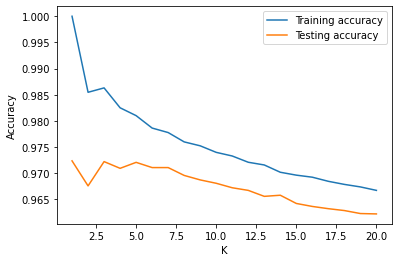

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier <---- imported the library at the start of the question


train_accs = []
test_accs = []

# try K values from 1 to 20
for k in tqdm(range(1, 21)):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# plot the accuracy as a function of K
plt.plot(range(1, 21), train_accs, label='Training accuracy')
plt.plot(range(1, 21), test_accs, label='Testing accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Looking at the graph, we can see that the testing accuracy is highest for K=3, and the training accuracy decreases as K increases. This suggests that K=3 is the optimal value of K for this dataset, as it gives good performance on the testing set while avoiding overfitting.

c) Using the best model from b), pick an image at random and plot it next to its K nearest neighbors (5pts)

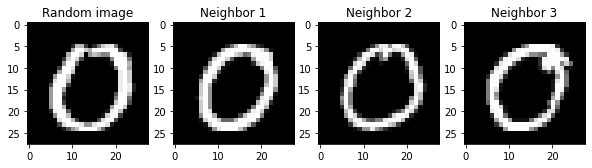

In [ ]:
# train a KNN model with K=3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# choose a random image from the testing set
random_index = np.random.randint(len(X_test))
random_image = X_test[random_index].reshape(28, 28)

# find the K nearest neighbors of the random image
_, indices = knn.kneighbors([X_test[random_index]])
neighbor_images = X_train[indices[0]].reshape(-1, 28, 28)

# plot the random image and its K nearest neighbors
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(random_image, cmap='gray')
plt.title('Random image')
for i in range(3):
    plt.subplot(1, 4, i+2)
    plt.imshow(neighbor_images[i], cmap='gray')
    plt.title(f'Neighbor {i+1}')
plt.show()

*NOTE:* output may vary due to choices made in picking k and plotting

d) Using a dimensionality reduction technique discussed in class, reduce the dimensionality of the dataset before applying a KNN model. Repeat b) and discuss similarities and differences to the previous model. Briefly discuss your choice of dimension and why you think the performance / accuracy of the model has changed. (10 points)

100%|██████████| 20/20 [11:17<00:00, 33.90s/it]


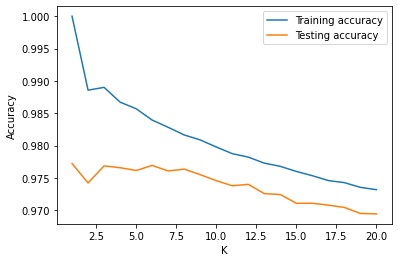

In [ ]:
#from sklearn.pipeline import make_pipeline <---- imported the library at the start of the question

"""
Basic code for this question

model = make_pipeline(PCA(n_components=50), KNeighborsClassifier(n_neighbors=3))
model.fit(X_train, y_train) 

"""

train_accs = []
test_accs = []

for k in tqdm(range(1, 21)):
    model = make_pipeline(PCA(n_components=50), KNeighborsClassifier(n_neighbors=k))
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# plot the accuracy as a function of K
plt.plot(range(1, 21), train_accs, label='Training accuracy')
plt.plot(range(1, 21), test_accs, label='Testing accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



*   Improved computational complexity
*   Improved accuracy (at best K, ie K=3)


The choice of 50 components for the PCA model is somewhat arbitrary. 
The performance of the model may have changed because the PCA model reduces the dimensionality of the data by projecting it onto a lower-dimensional subspace. This can sometimes help to reduce noise and extract meaningful features from the data.

## Bonus (20 points)

Complete the code below to support N-dimensional GMM clustering. Only use the methods imported below. Please take a look at the comments and docstrings for more info.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

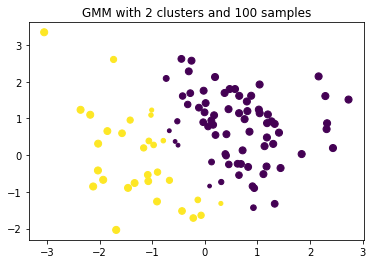

In [ ]:
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as sc_multivariate_normal
from numpy.random import multivariate_normal, uniform


#mark changes here - class definied
class Component:
    def __init__(self, weight, mean, cov):
        self.weight = weight
        self.mean = mean
        self.cov = cov  


nd_gmm = [
    Component(.25, [-1, 1], [[1, 0], [0, 1]]),
    Component(.50, [0, 0], [[1, 0], [0, 1]]),
    Component(.25, [1, 1], [[1, 0], [0, 1]])
]

def generate_nd_gmm_dataset(gmm_params, size):
    if not is_valid_nd_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        dataset += [multivariate_normal(comp.mean, comp.cov)] #mark changes here
    return array(dataset) # this should be a numpy array instead of a list   #mark changes here


def is_valid_nd_gmm(gmm_params):
    '''
        Check that all the dimensions are consistent
        accross all components
    '''
    dimensions = len(gmm_params[0].mean)  #mark changes from here
    for comp in gmm_params:
        if len(comp.mean) != dimensions or array(comp.cov).shape != (dimensions, dimensions):
            return False
    return is_valid_gmm(gmm_params)# checks if mixture components add to 1

#mark changes here - new function defined - reusing from a)
def is_valid_gmm(gmm_params):
    '''
        Check that the weights add up to 1
    '''
    return abs(sum([comp.weight for comp in gmm_params]) - 1) < 1e-6

#mark changes here - new function defined - reusing from a)
def get_random_component(gmm_params):
    '''
        Randomly pick a component according to its weight
    '''
    r = uniform()
    total = 0
    for comp in gmm_params:
        total += comp.weight
        if r <= total:
            return comp
    return gmm_params[-1]


def gmm_nd_init(k, dataset):
    kmeans = KMeans(k, init='k-means++').fit(dataset) #mark changes from here
    gmm_params = []
    for j in range(k):
        p_cj = sum([1 if kmeans.labels_[i] == j else 0 for i in range(len(dataset))]) / len(dataset)
        mean_j = sum([dataset[i] for i in range(len(dataset)) if kmeans.labels_[i] == j]) / sum([1 if kmeans.labels_[i] == j else 0 for i in range(len(dataset))])
        var_j = sum([(dataset[i] - mean_j).reshape(-1, 1) * (dataset[i] - mean_j).reshape(1, -1) for i in range(len(dataset)) if kmeans.labels_[i] == j]) / sum([1 if kmeans.labels_[i] == j else 0 for i in range(len(dataset))])
        gmm_params.append(Component(p_cj, mean_j, var_j))

    return gmm_params


def compute_nd_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j

        Here mean_j is a vector and var_j is a matrix
    '''
    gmm_params = []
    for j in range(k): #mark changed from here
        p_cj = sum([probs[i][j] for i in range(len(dataset))]) / len(dataset)
        mean_j = sum([probs[i][j] * dataset[i] for i in range(len(dataset))]) / sum([probs[i][j] for i in range(len(dataset))])
        var_j = sum([probs[i][j] * (dataset[i] - mean_j).reshape(-1, 1) * (dataset[i] - mean_j).reshape(1, -1) for i in range(len(dataset))]) / sum([probs[i][j] for i in range(len(dataset))])

        gmm_params += [Component(p_cj, mean_j, var_j)]

    return gmm_params



def compute_nd_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
        
        Here x_i are vectors
    '''
    probs = []
     #mark changes from here
    #assert all(isinstance(comp, dict) and 'mean' in comp and 'cov' in comp and isinstance(comp['mean'], np.ndarray) and isinstance(comp['cov'], np.ndarray) for comp in gmm_params), "Invalid format for GMM component parameters"

    for i in range(len(dataset)):
        p_cj_xi = []
        for j in range(k):
            p_cj_xi += [gmm_params[j].weight * sc_multivariate_normal.pdf(dataset[i], gmm_params[j].mean, gmm_params[j].cov)]
        p_cj_xi = p_cj_xi / sum(p_cj_xi)
        probs += [p_cj_xi]

    return probs


def expectation_maximization_nd(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_nd_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_nd_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_nd_gmm(k, dataset, probs)

    return probs, gmm_params


#defining new variable for ease of testing code
n_clust = 2
sample_size = 100

data = generate_nd_gmm_dataset(nd_gmm, sample_size)
probs, gmm_p = expectation_maximization_nd(n_clust, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=size)
plt.title('GMM with {} clusters and {} samples'.format(n_clust, sample_size)) #adding title to graph
plt.show()

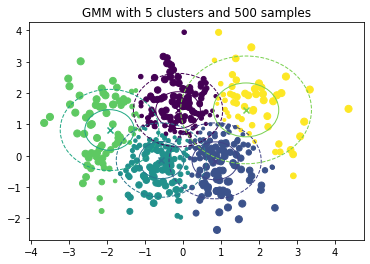

In [ ]:
#extra: not to be graded on basis of this


import numpy as np
#defining new variable for ease of testing code
n_clust = 5
sample_size = 500

data = generate_nd_gmm_dataset(nd_gmm, sample_size)
probs, gmm_p = expectation_maximization_nd(n_clust, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=size)

for i in range(n_clust):
    cluster_color = plt.cm.viridis(i/n_clust)
    plt.scatter(gmm_p[i].mean[0], gmm_p[i].mean[1], color=cluster_color, marker='x')
    
    plt.gca().add_artist(plt.Circle(gmm_p[i].mean, np.sqrt(gmm_p[i].cov[0][0]),   color=cluster_color, fill=False))
    plt.gca().add_artist(plt.Circle(gmm_p[i].mean, np.sqrt(gmm_p[i].cov[0][0])*2, color=cluster_color, fill=False, linestyle='dashed'))

#NOTE: added title to make it clearer
plt.title('GMM with {} clusters and {} samples'.format(n_clust, sample_size))
plt.show()